In [1]:
import numpy as np

In [2]:
K = 20 # number of ions

In [73]:
true_m = np.random.rand(K)
true_m.sort()
ss_m = 0.01

I = 5 # number of injections
ref_injection = 0

mi = np.zeros((K,I),np.double)

for i in range(I):
    mi[:,i] = np.random.normal(true_m,np.sqrt(ss_m))

    
gam =5
alpha = 0.1
mobs = np.zeros_like(mi)
for i in range(I):
    ki = np.zeros((K,K),np.double)
    for k in range(K):
        for kp in range(K):
            ki[k,kp] = alpha * np.exp(-gam*(mi[k,i] - mi[kp,i])**2)
    warp = np.random.multivariate_normal(np.zeros(K),ki)
    mobs[:,i] = mi[:,i] + warp

In [74]:
# make the opposite kernels
kernels = []
for i in range(I):
    ki = np.zeros((K,K),np.double)
    for k in range(K):
        for kp in range(K):
            ki[k,kp] = alpha * np.exp(-gam*(mi[k,i] - mi[kp,i])**2)
    kernels.append(ki)

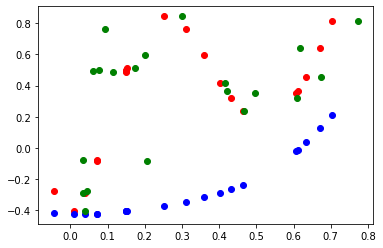

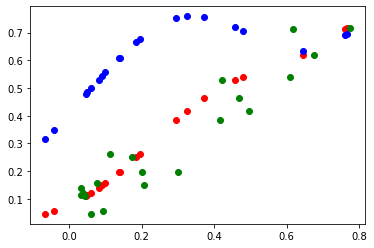

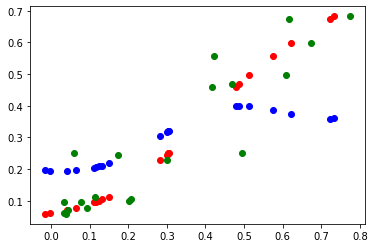

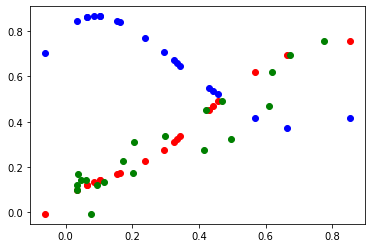

In [75]:
so = (ss_m)*np.eye(K)
soi = np.linalg.inv(so)
mes = np.zeros_like(mobs)
for i in range(I):
    if i == ref_injection:
        mes[:,i] = mi[:,i]
        continue
    ki = np.linalg.inv(kernels[i])
    cov = soi + ki
    cov = np.linalg.inv(cov)
    me = np.dot(cov,np.dot(soi,true_m) + np.dot(ki,mobs[:,i]))
    mes[:,i] = me
    plt.figure()
    plt.plot(mi[:,i],me,'ro')
    plt.plot(mi[:,i],mobs[:,i],'bo')
    plt.plot(true_m,me,'go')

In [21]:
print(type(sigma))

<class 'int'>


In [456]:
import numpy as np
from scipy.stats import norm
class GibbsGaussMix(object):
    def __init__(self,K,x,sigma,mu0,sigma0,alpha = 1):
        self.K = K
        self.x = x
        self.N,self.D = x.shape
        self.sigma = sigma
        self.sigma0 = sigma0
        if self.D > 1:
            self.sigma0_i = np.linalg.inv(self.sigma0)
            self.sigma_i = np.linalg.inv(self.sigma)
        
        self.mu0 = mu0
        self.alpha = alpha
        
        self.Z = np.zeros((self.N,self.K),np.int)
        self.a = None
        self.S = None
        
        self.n_report = 0
        self.all_n_k = []
        self.all_ZZ = np.zeros((N,N),dtype=np.int)
        
    def update_all_given_Z(self):
        self.cluster_sums = self.Z.sum(axis=0)
        self.sumx = np.zeros((self.K,self.D),np.double)
        for k in range(self.K):
            self.compute_S(k)
            self.sumx[k,:] = (self.x*self.Z[:,k][:,None]).sum(axis=0)
            self.compute_a(k)

        
    def randomise(self):
        self.Z = np.zeros((self.N,self.K),np.int)
        for n in range(self.N):
            k = np.random.choice(self.K)
            self.Z[n,k] = 1
        self.a = [None for k in range(self.K)]
        self.S = [None for k in range(self.K)]
        self.update_all_given_Z()
    
    def compute_S(self,k):
        if self.D == 1:
            self.S[k] = 1./(1./self.sigma0 + self.cluster_sums[k]*(1./self.sigma))
        else:
            self.S[k] = np.linalg.inv(self.sigma0_i + self.cluster_sums[k]*self.sigma_i)


    def compute_a(self,k):
        if self.D == 1:
            self.a[k] = self.S[k]*(self.mu0/self.sigma0 + self.sumx[k]/self.sigma)
        else:
            self.a[k] = np.dot(self.S[k],(np.dot(self.sigma0_i,self.mu0) + np.dot(self.sigma_i,self.sumx[k,:])[:,None])).flatten()




    def remove_from_cluster(self,i,k):
        assert self.Z[i,k] == 1
        self.Z[i,k] = 0
        self.cluster_sums[k] -= 1
        if self.D == 1:
            self.sumx[k] -= self.x[i]
        else:
            self.sumx[k,:] -= self.x[i,:]
        self.compute_S(k)
        self.compute_a(k)

    def add_to_cluster(self,i,k):
        assert self.Z[i,:].sum() == 0
        self.cluster_sums[k] += 1
        if self.D == 1:
            self.sumx[k] += self.x[i]
        else:
            self.sumx[k,:] += self.x[i,:]
        self.compute_S(k)
        self.compute_a(k)
        self.Z[i,k] = 1
    
    def prior(self):
        return np.log((self.cluster_sums + self.alpha/self.K)/(self.N-1+self.alpha))
    
    def collapsed_likelihood(self,i):
        if self.D == 1:
            likelihoods = np.array([-0.5*np.log(self.sigma+self.S[k]) for k in range(self.K)]).flatten()
            likelihoods -= np.array([0.5*(self.x[i]-self.a[k])**2/(self.sigma+self.S[k]) for k in range(self.K)]).flatten()
            likelihoods = likelihoods.flatten()
        else:
            # multivariate likelihood function
            likelihoods = np.array([-0.5*np.log(np.linalg.det(self.sigma + self.S[k])) for k in range(self.K)]).flatten()
            likelihoods -= np.array([np.dot(np.dot(x[i,:] - self.a[k],np.linalg.inv(self.sigma + self.S[k])),x[i,:]-self.a[k]) for k in range(self.K)]).flatten()
        return likelihoods

        
    def collapsed_update_individual(self,i):
        # update the cluster for i
        # remove point i from everything
        k = np.where(self.Z[i,:])[0][0]
        self.remove_from_cluster(i,k)
        priors = self.prior()
        likelihoods = self.collapsed_likelihood(i)
        temp = priors + likelihoods
        post = np.exp(temp - np.max(temp))
        post /= post.sum()
        newk = np.random.choice(range(len(post)),p=post)
        self.add_to_cluster(i,newk)
        

  
        
    def collapsed_update(self,n_its = 1,report = False):
        for it in range(n_its):
            for n in range(self.N):
                self.collapsed_update_individual(n)
            if report:
                self.all_n_k.append(self.K)
                self.all_ZZ += np.dot(self.Z,self.Z.T)
                self.n_report += 1
            
            
class InfiniteGibbsGaussMix(GibbsGaussMix):
    def prior(self):
        prior = np.hstack((self.cluster_sums,self.alpha))
        return np.log(prior/(self.N - 1 + self.alpha))
    def collapsed_likelihood(self,i):
        finite_likes = super().collapsed_likelihood(i)
        if self.D == 1:
            inf_like = -0.5*np.log(self.sigma + self.sigma0)
            inf_like -= 0.5*(self.x[i] - self.mu0)**2/(self.sigma + self.sigma0)
        else:
            inf_like = -0.5*np.log(np.linalg.det(self.sigma + self.sigma0))
            inf_like -= np.dot(np.dot(x[i,:] - self.mu0.flatten(),np.linalg.inv(self.sigma + self.sigma0)),x[i,:]-self.mu0.flatten())
        likelihoods = np.hstack((finite_likes,inf_like))
        return likelihoods
    def remove_from_cluster(self,i,k):
        super().remove_from_cluster(i,k)
        if self.cluster_sums[k] == 0:
            # delete the cluster
            self.Z = np.delete(self.Z,k,axis=1)
            self.cluster_sums = self.Z.sum(axis=0)
            del self.S[k]
            del self.a[k]
            self.sumx = np.delete(self.sumx,k,axis=0)
            self.K -= 1
#         self.test()
    def add_to_cluster(self,i,k):
        if k < self.K:
            super().add_to_cluster(i,k)
        else:
            self.K += 1
            self.Z = np.hstack((self.Z,np.zeros((N,1),np.int)))
            self.Z[i,k] = 1
            self.sumx = np.vstack((self.sumx,x[i,:]))
            self.cluster_sums = self.Z.sum(axis=0)
            self.a.append(None)
            self.S.append(None)
            self.compute_S(k)
            self.compute_a(k)
#         self.test()
            
    def test(self):
        test_cluster_sums = self.Z.sum(axis=0)
        test_sumx = [None for k in range(self.K)]
        test_a = [None for k in range(self.K)]
        test_S = [None for k in range(self.K)]
        for k in range(self.K):
            test_sumx[k] = (self.x*self.Z[:,k][:,None]).sum(axis=0)
            test_S[k] = 1./(1./self.sigma0 + test_cluster_sums[k]*(1./self.sigma))
            test_a[k] = test_S[k]*(self.mu0/self.sigma0 + test_sumx[k]/self.sigma)
            assert(test_cluster_sums[k] == self.cluster_sums[k]),"Cluster sum diff"
            assert abs(test_sumx[k]  - self.sumx[k])<1e-6,test_sumx[k]-self.sumx[k]
            

## 1-dimensional test


[[-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]]
(5, 1)
[array([1.0919064])]


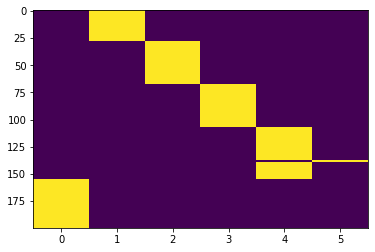

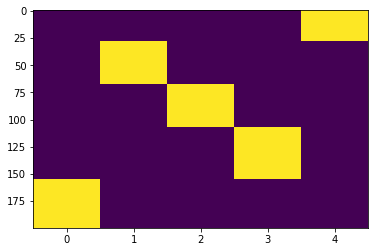

In [427]:
            
        
        
mu0 = 0
sigma0 = 100
sigma = 0.1
K = 5
m = np.random.normal(mu0,np.sqrt(sigma0),size=(K,1))
m[0][0] = -10
m[1][0] = -5
m[2][0] = 0
m[3][0] = 5
m[4][0] = 10
print(m)
print(m.shape)
m.sort(axis=0)
N = 200
x = []
truez = []
for n in range(N):
    k = np.random.choice(K)
    x.append(np.random.normal(m[k],np.sqrt(sigma)))
    truez.append(k)
    
xz = list(zip(x,truez))
xz.sort(key = lambda x: x[1])
x,truez = zip(*xz)
x = np.array(x)
g = InfiniteGibbsGaussMix(1,x,sigma,mu0,sigma0,alpha = 1)
g.randomise()

print(g.a)


g.collapsed_update(n_its = 10)


import pylab as plt
%matplotlib inline
plt.figure()
plt.imshow(g.Z,aspect='auto',interpolation='nearest')


g.collapsed_update(n_its = 50,report = True)
plt.figure()
plt.imshow(g.Z,aspect='auto',interpolation='nearest')

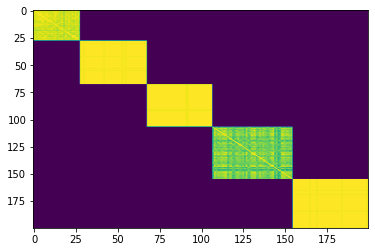

In [428]:
plt.imshow(g.all_ZZ/g.n_report,aspect='auto')

## 2-dimensional test

In [450]:
mu0 = np.array([[0.,0.]]).T
print(mu0.shape)
sig0 = np.array([[100.,0.],[0.,100.]])
print(sig0.shape)
sig = np.array([[0.1,0.],[0.,0.01]])
print(sig.shape)

(2, 1)
(2, 2)
(2, 2)


[[-10.           2.61484808]
 [ -5.          23.21302652]
 [  0.          35.03464336]
 [  5.         -11.44905254]
 [ 10.           7.1865235 ]]


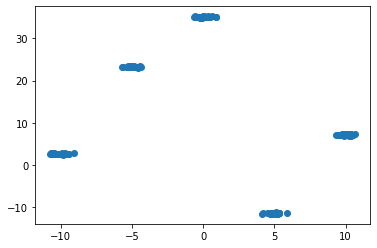

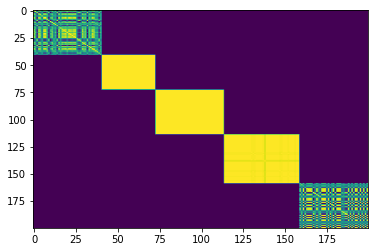

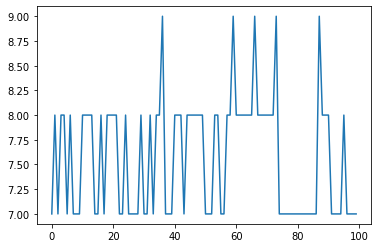

In [458]:
m = np.random.multivariate_normal(mu0.flatten(),sig0,size=(K))
m[0][0] = -10
m[1][0] = -5
m[2][0] = 0
m[3][0] = 5
m[4][0] = 10
print(m)

x = np.zeros((N,2))
truez = np.zeros(N)
for n in range(N):
    k = np.random.choice(K)
    x[n,:] = np.random.multivariate_normal(m[k,:],sig)
    truez[n] = k

idx = np.argsort(truez)
truez = truez[idx]
x = x[idx,:]
plt.figure()
plt.scatter(x[:,0],x[:,1])


g = InfiniteGibbsGaussMix(5,x,sig,mu0,sig0,alpha = 1)
g.randomise()
g.collapsed_update(n_its = 100)
g.collapsed_update(n_its = 100,report = True)
plt.figure()
plt.imshow(g.all_ZZ/g.n_report,aspect='auto')
plt.figure()
plt.plot(range(len(g.all_n_k)),g.all_n_k)

In [452]:
?plt.scatter

In [361]:
a = np.zeros((5,2),np.int)
print(a[2,].shape)

(2,)


In [366]:
print(g.a[0])

[[1.23085178]
 [2.13534118]]


In [382]:
print(np.dot(x[3,:],g.a[0]))
print(x[3,:]-g.a[0].flatten())

73.24821985408748
[-7.87166973 -9.04134662]


In [374]:
print(g.a[0].shape)

(2, 1)


In [375]:
print(x[3,:].shape)

(2,)
